In [366]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import networkx as nx
import copy
from itertools import chain, combinations   

In [367]:
class Vertex:
    def __init__(self, name):
        self.name = name

  A B C D E F G 
A 0 1 1 0 0 0 0 
B 1 0 0 1 1 0 0 
C 1 0 0 1 0 0 0 
D 0 1 1 0 1 1 0 
E 0 1 0 1 0 0 0 
F 0 0 0 1 0 0 1 
G 0 0 0 0 0 1 0 
['AB', 'AC', 'BD', 'BE', 'CD', 'DE', 'DF', 'FG']


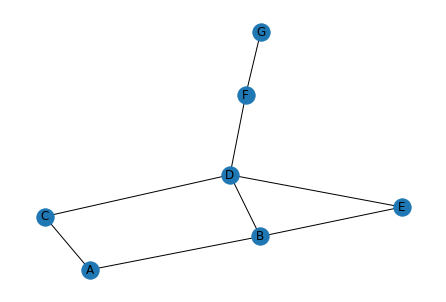

In [368]:
def get_key(d, val):
    for key, value in d.items():
         if val == value:
            return key
    return None


class Graph:
        
    def __init__(self, num_of_vertices):
        self.vertices = {}
        self.adj_matrix = []
        self.vertex_indices = {}
        for i in range(ord('A'), ord('A') + num_of_vertices):
            self.add_vertex(Vertex(chr(i)))
              
    
    def add_vertex(self, vertex):
        if vertex.name not in self.vertices:
            self.vertices[vertex.name] = vertex
            for row in self.adj_matrix:
                row.append(0)
            self.adj_matrix.append([0] * (len(self.adj_matrix) + 1))
            self.vertex_indices[vertex.name] = len(self.vertex_indices)
            return True
        else:
            return False
    
    def add_edge(self, edge):
        u = edge[:1]
        v = edge[1:]
        if u in self.vertices and v in self.vertices:
            self.adj_matrix[self.vertex_indices[u]][self.vertex_indices[v]] = 1;
            self.adj_matrix[self.vertex_indices[v]][self.vertex_indices[u]] = 1;
            return True
        else:
            return False
        
        
    def get_edges(self):
        edges = []
        offset = 1
        for u in range(len(self.adj_matrix)-1):
            for v in range(offset, len(self.adj_matrix[0])):
                if self.adj_matrix[u][v] == 1:
                    vertex1 = get_key(self.vertex_indices, u)
                    vertex2 = get_key(self.vertex_indices, v)
                    edges.append(vertex1+vertex2)                
            offset += 1
        return edges
        
        
    def print_graph(self):
        print('  ', end = '')
        for v in self.vertex_indices:
            print(v, end=' ')
        print()
        
        for v, i in sorted(self.vertex_indices.items()):
            print(v, end = ' ')
            for j in range(len(self.adj_matrix)):
                print(self.adj_matrix[i][j], end = ' ')
            print()
              
    def draw_graph(self):
        H = nx.from_numpy_matrix(np.array(self.adj_matrix))
    
        labeldict = {}
        for v, i in sorted(self.vertex_indices.items()):
            labeldict[i] = v
            
        nx.draw(H, labels = labeldict, with_labels=True)
                    
            
g = Graph(7)   
edges = set(['AB', 'AC', 'BD', 'BE', 'CD', 'DE', 'DF', 'FG'])
for edge in edges:
    g.add_edge(edge)

g.print_graph()
g.draw_graph()
print(g.get_edges())

In [369]:
def is_maximal_matching(graph, edges):
    graph_vertices = {k for k,v in graph.vertices.items()}
    unused_vertices = copy.deepcopy(graph_vertices)
    
    # provera da li je matching
    for e in edges:
        # prvi cvor u grani
        if e[:1] in graph_vertices:
            if e[:1] in unused_vertices:
                unused_vertices.remove(e[:1])
            else:
                # vec iskoriscen cvor (degV<=1, za svaki cvor)
                return False
        else:
            # nepoznat cvor 
            return False
        # drugi cvor u grani
        if e[1:] in graph_vertices:
            if e[1:] in unused_vertices:
                unused_vertices.remove(e[1:])
            else:
                return False
        else:
            return False
        
        # da li je grana u grafu
        if graph.adj_matrix[graph.vertex_indices[e[:1]]][graph.vertex_indices[e[1:]]] == 0:
            return False
        
    # provera da li je maximal, da li moze da se doda jos neka grana a da ostane matching
    for v in unused_vertices:
        # red u matrici za taj cvor
        neighbours_vector = graph.adj_matrix[graph.vertex_indices[v]] 
        for i in range(len(neighbours_vector)):
            u = get_key(graph.vertex_indices, i)
            if neighbours_vector[i] == 1 and u in unused_vertices and u!=v:     
                return False
            
    return True

In [370]:
candidate = set(['BA', 'DC', 'GF'])
is_maximal_matching(g, candidate)

True

In [371]:
def powerset_generator(edges):
      for subset in chain.from_iterable(combinations(edges, r) for r in range(len(edges)+1)):
        yield set(subset)
    

In [372]:
def mmm_brute_force(graph):
    for candidate in powerset_generator(graph.get_edges()):
        if is_maximal_matching(graph, candidate):
            break
 
    return candidate

In [373]:
minimum_maximal_matching = mmm_brute_force(g)
print(minimum_maximal_matching)

{'DF', 'AB'}


In [374]:
# bilo koji maximal matching je 2_aproksimacija
def greedy_2_approximation(graph):
    H = nx.from_numpy_matrix(np.array(graph.adj_matrix))
    mmm_aprox = set()
    for edge in nx.maximal_matching(H):
        u = get_key(graph.vertex_indices, edge[0])
        v = get_key(graph.vertex_indices, edge[1])
        mmm_aprox.add(u+v)
    return mmm_aprox

In [375]:
mmm_aprox = greedy_2_approximation(g)
print(mmm_aprox)

{'CD', 'AB', 'FG'}


In [376]:
def from_binary_to_list_of_pairs(graph, position):
    list_of_pairs = []
    graph_edges = graph.get_edges()
    for i in range(len(position)):
        list_of_pairs.append((graph_edges[i], position[i]))                      
    return list_of_pairs

def from_binary_to_list_of_edges(graph,position):
    list_of_edges = []
    graph_edges = graph.get_edges()
    for i in range(len(position)):
        if position[i] == 1:
            list_of_edges.append(graph_edges[i])              
    return list_of_edges                    
                             
                             
def calculate_fitness(graph, position):
    list_of_pairs = from_binary_to_list_of_pairs(graph, position)
    
    unused_vertices = {k for k,v in graph.vertices.items()}
 
    #problem: poziciona pristrasnost, grane koje dolaze leksikografski ispred ce biti verovatnije zadrzane
    for i in range(len(list_of_pairs)):
        if list_of_pairs[i][1] == 0:
            continue                 
        
        # cvorovi u grani
        a = list_of_pairs[i][0][:1]
        b = list_of_pairs[i][0][1:]
            
        if a in unused_vertices and b in unused_vertices:
            unused_vertices.remove(a)
            unused_vertices.remove(b)         
        else:
            # neki od cvorova vec iskoriscen, izbaci granu
            position[i] = 0
            continue                 
   
    # ne moze da se istovremeno iterira i brise, mora kopija
    unused_vertices_copy = unused_vertices.copy()
    for v in unused_vertices_copy:
        # dodatna provera
        if v not in unused_vertices:
            continue
        neighbours_vector = graph.adj_matrix[graph.vertex_indices[v]]
        # problem: uvek dodaje granu ka leksikografski prvom neiskoriscenom susedu kojeg pronadje
        for i in range(len(neighbours_vector)):
            u = get_key(graph.vertex_indices, i)                 
            if neighbours_vector[i] == 1 and u in unused_vertices and u!=v:
                # u listi su cvorovi u grani leksikografski sortirani
                if u < v:
                    edge_to_add = u+v
                else:
                    edge_to_add = v+u
                edges_list = [a for (a,b) in list_of_pairs]
                index = edges_list.index(edge_to_add)
                position[index] = 1
                unused_vertices.remove(v)
                unused_vertices.remove(u)
                # break unutrasnje petlje
                break
                
    return sum(position)



def calculate_fitness_v2(graph, position):
    list_of_pairs = from_binary_to_list_of_pairs(graph, position)
    # enumerate da bismo savucali originalne indekse grana u listi
    list_of_pairs_enum = list(enumerate(list_of_pairs))
    random.shuffle(list_of_pairs_enum)
    
    unused_vertices = {k for k,v in graph.vertices.items()}
    #unused_vertices = [k for k,v in graph.vertices.items()]

    for i in range(len(list_of_pairs_enum)):
        if list_of_pairs_enum[i][1][1] == 0:
            continue                 
        
        a = list_of_pairs_enum[i][1][0][:1]
        b = list_of_pairs_enum[i][1][0][1:]
            
        if a in unused_vertices and b in unused_vertices:
            unused_vertices.remove(a)
            unused_vertices.remove(b)         
        else:
            position[list_of_pairs_enum[i][0]] = 0
            continue                 
   
    #random.shuffle(unused_vertices)
    unused_vertices_copy = unused_vertices.copy()
    for v in unused_vertices_copy:
        if v not in unused_vertices:
            continue
        neighbours_vector = graph.adj_matrix[graph.vertex_indices[v]]
        # indeksi suseda ka kojima postoji grana i neiskorisceni su
        indices = [index for index, element in enumerate(neighbours_vector) if element == 1 
                   and get_key(graph.vertex_indices, index) in unused_vertices and get_key(graph.vertex_indices, index) != v]
        
        # ako nema takvih predji na sledeci
        if not indices:
            continue
        
        # slucajno odabrati jednog
        chosed = random.choice(indices)
        u = get_key(graph.vertex_indices, chosed)
                 
        if u < v:
            edge_to_add = u+v
        else:
            edge_to_add = v+u
            
        edges_list = [a for (a,b) in list_of_pairs]
        index = edges_list.index(edge_to_add)
        position[index] = 1
        unused_vertices.remove(v)
        unused_vertices.remove(u)
        
                
    return sum(position)


 
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def determine(x):
    rand_gen = random.uniform(0,1)
    if rand_gen >= sigmoid(x):
        return 0
    else:
        return 1

class Particle:
    globalBestPosition = None
    globalBestValue = None
     
    def __init__(self, graph, fitness_func, phi, velocity_bounds):
        
        self.graph = graph
        self.fitness_func = fitness_func
    
        pos = []
        for i in range(len(self.graph.get_edges())):
            pos.append(random.randint(0,1))
                
        self.position = np.array(pos)
        self.velocity = np.zeros(len(self.position))
        self.currValue = self.fitness_func(self.graph, self.position)                     
        self.bestPosition = np.array(self.position)
        self.bestValue = self.currValue
                             
        if Particle.globalBestValue is None or self.currValue < Particle.globalBestValue:
            Particle.globalBestPosition = np.array(self.position)
            Particle.globalBestValue = self.currValue     
        
        self.velocity_bounds = [velocity_bounds for pos in self.position]
        self.w = 1 / ((phi - 1) + math.sqrt(phi**2 - 2*phi))
        self.c1 = phi * self.w
        self.c2 = phi * self.w
    
    
    def updatePosition(self):
        self.position = list(map(determine,self.velocity))
        
        self.currValue = self.fitness_func(self.graph, self.position)
        if self.currValue < self.bestValue:
            self.bestValue = self.currValue
            self.bestPosition = np.array(self.position)
            if self.currValue < Particle.globalBestValue:
                Particle.globalBestValue = self.currValue
                Particle.globalBestPosition = np.array(self.position)     
        
    def updateVelocity(self):
        lower_bounds = np.array([x[0] for x in self.velocity_bounds])
        upper_bounds = np.array([x[1] for x in self.velocity_bounds])
        
        
        r1 = np.random.random(self.velocity.shape)
        r2 = np.random.random(self.velocity.shape)
        velocity = (self.w * self.velocity + r1 * self.c1 * (self.bestPosition - self.position) + r2 * self.c2 * (Particle.globalBestPosition - self.position)) 
        
        self.velocity = np.clip(self.velocity, lower_bounds, upper_bounds)
        
    def mutation(self, mutation_prob):
        for i in range(len(self.velocity)):
            if random.random() < mutation_prob:
                self.velocity[i] = -self.velocity[i]
        

In [377]:
SWARM_SIZE = 50
MAX_ITER = 500
# phi uzima iz [2.01, 2.4]
PHI = 2.07
MUTATION_PROB = 0.1
BOUNDS = (-4,4)

def BinaryPSO(graph, swarm_size=SWARM_SIZE, iterations=MAX_ITER, phi = PHI, mutation=True, mut_prob=MUTATION_PROB, vel_bounds=BOUNDS):
  
    swarm = [Particle(graph, calculate_fitness_v2, phi, vel_bounds) for _ in range(swarm_size)]
    
    bestValues = []
    for i in range(iterations):
        for particle in swarm:
            particle.updateVelocity()
            if(mutation == True):
                particle.mutation(mut_prob)
            
            particle.updatePosition()
    
        bestValues.append(Particle.globalBestValue)
    
    print(f'Solution: {Particle.globalBestPosition}, value: {Particle.globalBestValue}')

    mmm_found = from_binary_to_list_of_edges(graph, Particle.globalBestPosition)
    print(f'Minimum maximal matching found: {mmm_found}')
    plt.plot(range(iterations), bestValues)
    
    Particle.globalBestPosition = None
    Particle.globalBestValue = None
    return mmm_found
    

Solution: [1 0 0 0 0 0 1 0], value: 2
Minimum maximal matching found: ['AB', 'DF']


['AB', 'DF']

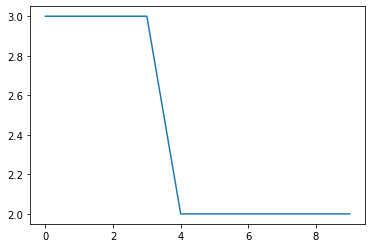

In [378]:
BinaryPSO(g, swarm_size=5, iterations=10)

In [379]:
def random_graph_generator(a,b):
    number_of_vertices = random.randint(a,b)
    print(f"Number of vertices = {number_of_vertices}")
    random_graph = Graph(number_of_vertices)
    # n*(n-1) / 2
    number_of_edges = random.randint(1, number_of_vertices*(number_of_vertices-1)/2)
    possible_vertices = [chr(i) for i in range(ord('A'), ord('A') + number_of_vertices)]
    
    for i in range(number_of_edges):
        random_edge = ''.join(random.choices(possible_vertices, k=2))
        random_graph.add_edge(random_edge)
    
    #random_graph.print_graph()
    return random_graph, number_of_vertices

In [380]:
def erdos_renyi_random_graph(a,b, p=0.5):
    num_of_vertices = random.randint(a,b)
    random_graph = Graph(num_of_vertices)
    
    for i in range(num_of_vertices):
        for j in range(num_of_vertices):
            if i != j:
                r = random.uniform(0,1)
                if r <= p:
                    vertex1 = get_key(random_graph.vertex_indices,i)
                    vertex2 = get_key(random_graph.vertex_indices,j)
                    edge = vertex1 + vertex2
                    random_graph.add_edge(edge)
    
    #random_graph.print_graph()
    return random_graph   

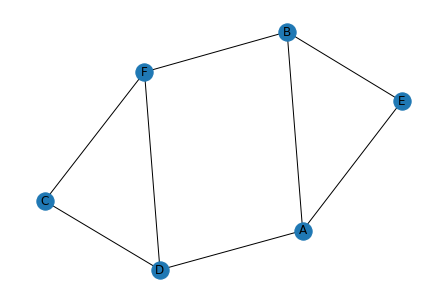

In [381]:
er_random_graph = erdos_renyi_random_graph(5,10, p=0.3)
er_random_graph.draw_graph()

In [387]:
random_graph, V = random_graph_generator(30,70)
E = len(random_graph.get_edges())
print(f"Number of edges = {E}")
d = 2*E /(V * (V-1))
print(f"Edge density = {d}")

Number of vertices = 66
Number of edges = 1328
Edge density = 0.6191142191142192


In [388]:
#mmm = mmm_brute_force(random_graph)
#print(mmm)
#print(len(mmm))

mmm_aprox_1 = greedy_2_approximation(random_graph)
print(mmm_aprox_1)
print(len(mmm_aprox_1))
print(is_maximal_matching(random_graph, mmm_aprox_1))

{'ef', 'ln', 'ST', 'MP', '{|', 'JN', 'CD', 'tu', 'XZ', '\\_', 'UY', 'ad', 'LO', 'QR', 'jm', 'vw', 'ik', 'gh', 'pr', '[]', '}~', 'oq', 'IK', '`c', 'EF', 'AB', 'GH', 'sy', '\x7f\x81', 'xz', '^b', 'VW'}
32
True


Solution: [0 0 0 ... 0 0 0], value: 31
Minimum maximal matching found: ['Am', 'B`', 'CE', 'D\x82', 'F[', 'GJ', 'HV', 'IN', 'Kf', 'Lr', 'My', 'Oj', 'Ps', 'QX', 'RU', 'SW', 'Tu', 'Y_', '\\t', ']a', '^|', 'b~', 'co', 'ev', 'gq', 'h\x80', 'in', 'kl', 'xz', '{\x7f', '}\x81']
True


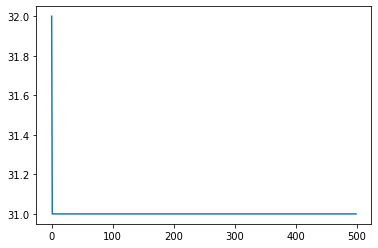

In [389]:
mmm_found = BinaryPSO(random_graph)
print(is_maximal_matching(random_graph, mmm_found))

In [330]:
#random_graph.draw_graph()

In [331]:
# genotype-phenotype concept
class ModifiedParticle:
    globalBestPhenotype = None
    globalBestValue = None
     
    def __init__(self, graph, fitness_func, phi, genotype_bounds):
        
        self.graph = graph
        self.fitness_func = fitness_func
    
        pos = []
        for i in range(len(self.graph.get_edges())):
            pos.append(random.randint(0,1))
                
        self.phenotype = np.array(pos)
        self.genotype = np.zeros(len(self.phenotype))
        self.velocity = np.zeros(len(self.phenotype))
        self.currValue = self.fitness_func(self.graph, self.phenotype)                     
        self.bestPhenotype = np.array(self.phenotype)
        self.bestValue = self.currValue
                             
        if ModifiedParticle.globalBestValue is None or self.currValue < ModifiedParticle.globalBestValue:
            ModifiedParticle.globalBestPhenotype = np.array(self.phenotype)
            ModifiedParticle.globalBestValue = self.currValue     
        
        self.genotype_bounds = [genotype_bounds for pos in self.phenotype]
        self.w = 1 / ((phi - 1) + math.sqrt(phi**2 - 2*phi))
        self.c1 = phi * self.w
        self.c2 = phi * self.w
    
    
    def updatePhenotype(self):
        self.phenotype = list(map(determine, self.genotype))
        
        self.currValue = self.fitness_func(self.graph, self.phenotype)
        if self.currValue < self.bestValue:
            self.bestValue = self.currValue
            self.bestPhenotype = np.array(self.phenotype)
            if self.currValue < ModifiedParticle.globalBestValue:
                ModifiedParticle.globalBestValue = self.currValue
                ModifiedParticle.globalBestPhenotype = np.array(self.phenotype)     
        
    def updateVelocity(self):    
        r1 = np.random.random(self.velocity.shape)
        r2 = np.random.random(self.velocity.shape)
        self.velocity = (self.w * self.velocity + r1 * self.c1 * (self.bestPhenotype - self.phenotype) + r2 * self.c2 * (ModifiedParticle.globalBestPhenotype - self.phenotype)) 
        
   
    def updateGenotype(self):
        lower_bounds = np.array([x[0] for x in self.genotype_bounds])
        upper_bounds = np.array([x[1] for x in self.genotype_bounds])
        
        self.genotype = np.clip(self.genotype+self.velocity, lower_bounds, upper_bounds)
          
        
    def mutation(self, mutation_prob):
        for i in range(len(self.genotype)):
            if random.random() < mutation_prob:
                self.genotype[i] = -self.genotype[i]



In [332]:
SWARM_SIZE = 50
MAX_ITER = 500
# phi uzima iz [2.01, 2.4]
PHI = 2.07
MUTATION_PROB = 0.1
BOUNDS = (-4,4)

def ModifiedBinaryPSO(graph, swarm_size=SWARM_SIZE, iterations=MAX_ITER, phi = PHI, mutation=True, mut_prob=MUTATION_PROB, gen_bounds=BOUNDS):
  
    swarm = [ModifiedParticle(graph, calculate_fitness_v2, phi, gen_bounds) for _ in range(swarm_size)]
    
    bestValues = []
    for i in range(iterations):
        for particle in swarm:
            particle.updateVelocity()
            particle.updateGenotype()
            
            if(mutation == True):
                particle.mutation(mut_prob)
            
            particle.updatePhenotype()
    
        bestValues.append(ModifiedParticle.globalBestValue)
    
    print(f'Solution: {ModifiedParticle.globalBestPhenotype}, value: {ModifiedParticle.globalBestValue}')

    mmm_found = from_binary_to_list_of_edges(graph, ModifiedParticle.globalBestPhenotype)
    print(f'Minimum maximal matching found: {mmm_found}')
    plt.plot(range(iterations), bestValues)
    
    ModifiedParticle.globalBestPhenotype = None
    ModifiedParticle.globalBestValue = None
    return mmm_found

Solution: [0 0 0 ... 0 0 0], value: 31
Minimum maximal matching found: ['Aq', 'BV', 'Ci', 'Ez', 'Fw', 'Gl', 'Id', 'JN', 'Ku', 'L`', 'MX', 'PQ', 'R\x82', 'Ss', 'Tm', 'Ut', 'Wp', 'Y_', 'Z~', '[c', '\\g', ']{', '^r', 'a}', 'bv', 'ef', 'h\x7f', 'j|', 'kx', 'n\x80', 'oy']
True


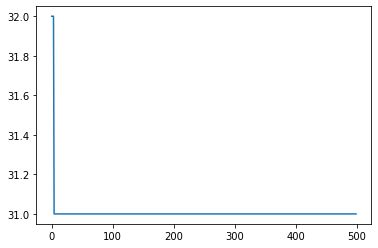

In [390]:
mmm_found_modified = ModifiedBinaryPSO(random_graph)
print(is_maximal_matching(random_graph, mmm_found_modified))

In [334]:
# local best implementacija
class ParticleV2:
    
    def __init__(self, pso_instance, index, fitness_func, phi, velocity_bounds):
        
        self.pso_instance = pso_instance
        self.fitness_func = fitness_func
        self.index = index
    
        pos = []
        for i in range(len(self.pso_instance.graph.get_edges())):
            pos.append(random.randint(0,1))
                
        self.position = np.array(pos)
        self.velocity = np.zeros(len(self.position))
        self.currValue = self.fitness_func(self.pso_instance.graph, self.position)                     
        self.bestPosition = np.array(self.position)
        self.bestValue = self.currValue
                          
        self.velocity_bounds = [velocity_bounds for pos in self.position]
        self.w = 1 / ((phi - 1) + math.sqrt(phi**2 - 2*phi))
        self.c1 = phi * self.w
        self.c2 = phi * self.w
    
    
    def updatePosition(self):
        self.position = list(map(determine,self.velocity))
        
        self.currValue = self.fitness_func(self.pso_instance.graph, self.position)
        if self.currValue < self.bestValue:
            self.bestValue = self.currValue
            self.bestPosition = np.array(self.position)    
        
    def updateVelocity(self):
        lower_bounds = np.array([x[0] for x in self.velocity_bounds])
        upper_bounds = np.array([x[1] for x in self.velocity_bounds])
        
        
        r1 = np.random.random(self.velocity.shape)
        r2 = np.random.random(self.velocity.shape)
        velocity = (self.w * self.velocity +
                    r1 * self.c1 * (self.bestPosition - self.position) +
                    r2 * self.c2 * (self.pso_instance.best_found_position_in_every_neighbourhood[self.index][0] - self.position)) 
        
        self.velocity = np.clip(self.velocity, lower_bounds, upper_bounds)
        
    def mutation(self, mutation_prob):
        for i in range(len(self.velocity)):
            if random.random() < mutation_prob:
                self.velocity[i] = -self.velocity[i]
                
    #def updateWeights(self):
    #    # 0.9 ----> 0.4
    #    self.w -= 0.1
    #    new_value = random.uniform(1.2, 2)
    #    self.c1 = new_value
    #    self.c2 = new_value



In [335]:
#WEIGHTS = [0.9, 2.0, 2.0]
class LocalBPSO:
    def __init__(self, graph, topology='ring', swarm_size=SWARM_SIZE, phi = PHI, vel_bounds=BOUNDS):
        self.graph = graph
        self.topology = topology
        self.swarm_size = swarm_size    
        self.swarm = [ParticleV2(self, i, calculate_fitness_v2, phi, vel_bounds) for i in range(swarm_size)]
        
        self.initialize_neighbourhoods()
        self.find_best_in_neighbourhoods()
    
    def initialize_neighbourhoods(self):
        n = self.swarm_size
        
        if self.topology not in ("von_neumann", "ring"):
            raise Exception(f"Unknown topology {self.topology}")
    
        # levi i desni sused 
        elif self.topology == "ring":
            self.neighbourhoods = np.zeros((n, 3), dtype=int)
            for i in range(n):
                self.neighbourhoods[i] = [(i-1)%n, i, (i+1)%n]
        
        #redom: gornji, donji, desni, levi sused
        elif self.topology == "von_neumann":
            n_sqrt = int(np.sqrt(n))
            if not n_sqrt**2 == n:
                raise Exception(f"Invalid swarm_size for Von Neumann topology: {n}")
            self.neighbourhoods = np.zeros((n, 5), dtype=int)   
            for i in range(n):
                self.neighbourhoods[i] = [i,                                            
                    (i - n_sqrt) % n,                              
                    (i + n_sqrt) % n,                              
                    ((i // n_sqrt) * n_sqrt) + ((i + 1) % n_sqrt),  
                    ((i // n_sqrt) * n_sqrt) + ((i - 1) % n_sqrt)   
                    ]
                
    def find_best_in_neighbourhoods(self):
        self.best_found_position_in_every_neighbourhood = []
        for ngh in self.neighbourhoods:
            best_value = math.inf
            best_position = np.array([])
            for i in ngh:
                if self.swarm[i].bestValue < best_value:
                    best_value = self.swarm[i].bestValue
                    best_position = np.array(self.swarm[i].bestPosition)
            self.best_found_position_in_every_neighbourhood.append((best_position, best_value))
        
    def optimize(self,iterations=MAX_ITER, mutation=True, mut_prob=MUTATION_PROB):
        
        bestValues = []
        values = [b for (a,b) in self.best_found_position_in_every_neighbourhood]
        bestValues.append(min(values))
           
        for i in range(iterations):
            for particle in self.swarm:
                particle.updateVelocity()
                
                if(mutation == True):
                    particle.mutation(mut_prob)
                    
                particle.updatePosition()  
                
               # if i % (iterations // 6) == 0:
               #     particle.updateWeights()
                
            
            self.find_best_in_neighbourhoods()
            bestValues.append(min([b for (a,b) in self.best_found_position_in_every_neighbourhood]))
    
        
        # najmanja vrednost u svim susedstvima
        ind = np.argmin([b for (a,b) in self.best_found_position_in_every_neighbourhood])
        best_position = self.best_found_position_in_every_neighbourhood[ind][0]
        print(f'Solution: {best_position}, value: {min([b for (a,b) in self.best_found_position_in_every_neighbourhood])}')

        mmm_found = from_binary_to_list_of_edges(self.graph, best_position)
        print(f'Minimum maximal matching found: {mmm_found}')
        plt.plot(range(iterations+1), bestValues)
        return mmm_found             

Solution: [1 0 0 0 0 0 1 0], value: 2
Minimum maximal matching found: ['AB', 'DF']
True


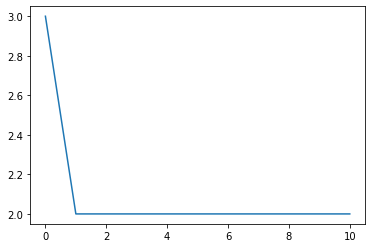

In [352]:
mmm_lbest = LocalBPSO(g, swarm_size=5).optimize(iterations=10)
print(is_maximal_matching(g, mmm_lbest))

Solution: [0 0 0 ... 0 0 0], value: 30
Minimum maximal matching found: ['AR', 'BJ', 'C{', 'DT', 'E\x80', 'Fh', 'HQ', 'Il', 'K[', 'Ly', 'Mt', 'Nk', 'OZ', 'Pi', 'S`', 'Uu', 'VW', 'Xa', 'Y\x82', '\\\x81', ']e', '^g', '_\x7f', 'b}', 'dm', 'jz', 'o~', 'ps', 'qw', 'x|']
True


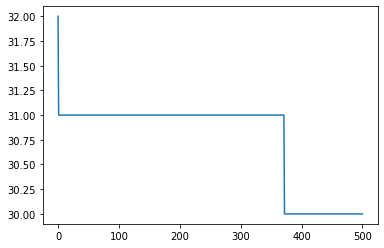

In [391]:
mmm_lbest_ring = LocalBPSO(random_graph).optimize()
print(is_maximal_matching(random_graph, mmm_lbest_ring))

Solution: [0 0 0 ... 0 0 0], value: 31
Minimum maximal matching found: ['At', 'BW', 'CX', 'D\\', 'Ep', 'F\x80', 'G\x7f', 'HS', 'I{', 'Jx', 'Kj', 'L_', 'Nq', 'PZ', 'Q^', 'Rw', 'Tg', 'U\x81', 'Vu', 'Y}', '[|', ']a', '`e', 'bo', 'cz', 'fs', 'h~', 'ik', 'ln', 'mr', 'vy']
True


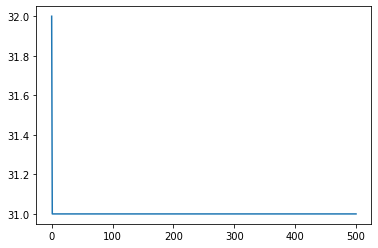

In [392]:
mmm_lbest_von_neumann = LocalBPSO(random_graph, topology="von_neumann", swarm_size=49).optimize()
print(is_maximal_matching(random_graph, mmm_lbest_von_neumann))

In [339]:
from docplex.mp.model import Model

In [345]:
def ILP_MMM(graph):
    model = Model('mmm')

    model.set_time_limit(100)
    
    
    dim = len(graph.vertices)
    x = model.binary_var_matrix(dim, dim, name = 'x' )
    
    adj_matrix = graph.adj_matrix
    for i in range(dim):
        for j in range(dim):
            if adj_matrix[i][j] == 0 or i==j:
                model.add_constraint(x[i,j]==0)
            else:
                model.add_constraint(x[i,j] == x[j,i])
    
    model.add_constraints([sum([x[i,j] for j in range(dim)]) <= 1 for i in range(dim)])
   
    for i in range(dim):
        for j in range(dim):
            if adj_matrix[i][j] == 1:
                model.add_constraint(x[i,j] + sum([x[i,k] for k in range(dim) if k!=j]) + sum([x[k,j] for k in range(dim) if k!=i]) >= 1)
    

    model.minimize(sum(x[i,j] for i in range(dim) for j in range(dim)))
    
    s = model.solve() 
    s.display()
    

In [341]:
ILP_MMM(g)

solution for: mmm
objective: 4
x_0_1 = 1
x_1_0 = 1
x_3_5 = 1
x_5_3 = 1


In [393]:
# vraca 2 * broj grana u mmm (neusmeren graf, matrica povezanosti je simetricna)
ILP_MMM(random_graph)

solution for: mmm
objective: 60
x_0_45 = 1
x_1_5 = 1
x_2_49 = 1
x_3_12 = 1
x_4_50 = 1
x_5_1 = 1
x_6_46 = 1
x_7_24 = 1
x_10_54 = 1
x_11_44 = 1
x_12_3 = 1
x_13_40 = 1
x_14_37 = 1
x_15_38 = 1
x_16_64 = 1
x_19_62 = 1
x_20_47 = 1
x_21_52 = 1
x_22_26 = 1
x_23_36 = 1
x_24_7 = 1
x_25_39 = 1
x_26_22 = 1
x_27_28 = 1
x_28_27 = 1
x_29_55 = 1
x_30_65 = 1
x_31_42 = 1
x_33_35 = 1
x_34_41 = 1
x_35_33 = 1
x_36_23 = 1
x_37_14 = 1
x_38_15 = 1
x_39_25 = 1
x_40_13 = 1
x_41_34 = 1
x_42_31 = 1
x_43_53 = 1
x_44_11 = 1
x_45_0 = 1
x_46_6 = 1
x_47_20 = 1
x_49_2 = 1
x_50_4 = 1
x_51_60 = 1
x_52_21 = 1
x_53_43 = 1
x_54_10 = 1
x_55_29 = 1
x_56_57 = 1
x_57_56 = 1
x_58_59 = 1
x_59_58 = 1
x_60_51 = 1
x_61_63 = 1
x_62_19 = 1
x_63_61 = 1
x_64_16 = 1
x_65_30 = 1


In [343]:
#for i in range(20):
#    random_graph, V = random_graph_generator(30,70)
#    E = len(random_graph.get_edges())
#    print(f"Number of edges = {E}")
#    d = 2*E /(V * (V-1))
#    print(f"Edge density = {d}")
    
#    mmm_aprox_1 = greedy_2_approximation(random_graph)
#    print(len(mmm_aprox_1))
    
#    ILP_MMM(random_graph)
    
#    print('---------------------------------')    
    

In [347]:
#for i in range(20):
#    random_graph = erdos_renyi_random_graph(30,70, p=0.8)
#    V = len(random_graph.vertices)
#    print(f"Number of vertices = {V}")
#    E = len(random_graph.get_edges())
#    print(f"Number of edges = {E}")
    
        
#    mmm_2_aprox = greedy_2_approximation(random_graph)
#    print(mmm_2_aprox)
#    print(len(mmm_2_aprox))
#    print(is_maximal_matching(random_graph, mmm_2_aprox))
       
#    mmm_found_bpso = BinaryPSO(random_graph)
#    print(is_maximal_matching(random_graph, mmm_found_bpso))
    
#    mmm_found_modified = ModifiedBinaryPSO(random_graph)
#    print(is_maximal_matching(random_graph, mmm_found_modified))
    
#    mmm_lbest_ring = LocalBPSO(random_graph).optimize()
#    print(is_maximal_matching(random_graph, mmm_lbest_ring))
    
#    mmm_lbest_von_neumann = LocalBPSO(random_graph, topology="von_neumann", swarm_size=49).optimize()
#    print(is_maximal_matching(random_graph, mmm_lbest_von_neumann))
    
#    ILP_MMM(random_graph)
#    print('--------------------------------------------------------------------------------------------')